In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Loading the dataset with labels

Random Validation Images:


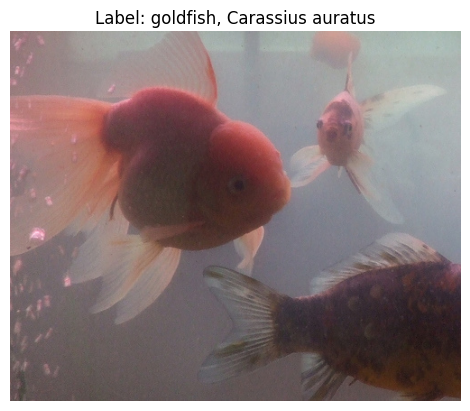

Random Training Images:


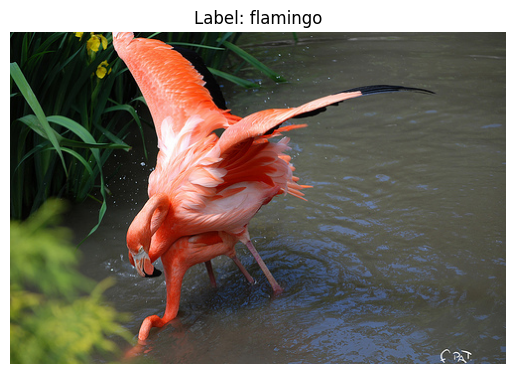

In [2]:
import json
import os
import random
import matplotlib.pyplot as plt
import cv2

# Load labels from JSON file
with open('/kaggle/input/imagenet100/Labels.json', 'r') as f:
    labels = json.load(f)

# Create a mapping from class ID to class name
id_to_class = {str(k): v for k, v in labels.items()}

# Function to display an image with its label
def show_image_with_label(image_path, label):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.title(f'Label: {label}')
    plt.axis('off')
    plt.show()

# Directories containing the images
base_train_dir = '/kaggle/input/imagenet100'
val_dir = os.path.join(base_train_dir, 'val.X')
train_dirs = [os.path.join(base_train_dir, f'train.X{i}') for i in range(1, 5)]

# Helper function to get a random sample of images from a directory
def get_random_images(data_dirs, num_samples=5):
    images = []
    all_files = []
    for data_dir in data_dirs:
        for label_id in os.listdir(data_dir):
            class_name = id_to_class.get(label_id, 'Unknown')
            files = os.listdir(os.path.join(data_dir, label_id))
            all_files.extend([(os.path.join(data_dir, label_id, filename), class_name) for filename in files])

    selected_files = random.sample(all_files, num_samples)
    for image_path, class_name in selected_files:
        images.append((image_path, class_name))
    return images

# Get random images from validation set
val_images = get_random_images([val_dir], 1)

# Get random images from all training directories
train_images = get_random_images(train_dirs, 1)

# Display random validation images
print("Random Validation Images:")
for image_path, label in val_images:
    show_image_with_label(image_path, label)

# Display random training images
print("Random Training Images:")
for image_path, label in train_images:
    show_image_with_label(image_path, label)

# Setting up Dataset and Dataloaders

In [3]:
# Creating the transforms
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from PIL import Image

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [4]:
# Create a custom dataset class
class MultiFolderDataset(Dataset):
    def __init__(self, folders, transform=None):
        self.samples = []
        self.transform = transform
        for folder in folders:
            for label_id in os.listdir(folder):
                class_name = id_to_class.get(label_id, 'Unknown')
                files = os.listdir(os.path.join(folder, label_id))
                self.samples.extend([(os.path.join(folder, label_id, filename), label_id) for filename in files])
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(sorted(id_to_class.keys()))}

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]
        image = Image.open(path).convert("RGB")
        if self.transform is not None:
            image = self.transform(image)
        label = self.class_to_idx[label]
        return image, label

In [5]:
import torchvision.datasets as datasets
# Creating the Datasets
train_dataset = MultiFolderDataset(train_dirs, transform=transform)
val_dataset = datasets.ImageFolder(val_dir, transform=transform)

In [6]:
# DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Setting up the Model

In [7]:
# Setting up device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [8]:
!git clone https://github.com/dicarlolab/CORnet.git

Cloning into 'CORnet'...
remote: Enumerating objects: 155, done.
remote: Counting objects: 100% (20/20), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 155 (delta 13), reused 9 (delta 8), pack-reused 135
Receiving objects: 100% (155/155), 68.11 KiB | 758.00 KiB/s, done.
Resolving deltas: 100% (87/87), done.


In [9]:
# Navigate to the cloned repository folder
import os
os.chdir('/kaggle/working/CORnet')

# Install the package if needed
!pip install .

Processing /kaggle/working/CORnet
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.4/88.4 kB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
  Created wheel for CORnet: filename=CORnet-0.1.0-py3-none-any.whl size=23228 sha256=1fafcd7435674988268f1634479b47e9d8256afe6b801065e4ee57c8a5dc9830
  Stored in directory: /tmp/pip-ephem-wheel-cache-2a5e3awk/wheels/ab/bb/f9/8716bf8cc3f23c0cd07d33b31c64ed0bc87023663d6be90ad5
  Created wheel for fire: filename=fire-0.6.0-py2.py3-none-any.whl size=117031 sha256=9b6d34de570d90cbc3b9250a98e3dfb5784f1ed44e70d2779408d7cfcb5e445e
  Stored in directory: /root/.cache/pip/wheels/d6/6d/5d/5b73fa0f46d01a793713f8859201361e9e581ced8c75e5c6a3
Successfully built CORnet fire


In [10]:
# Import the CORnet-S model architecture
from cornet import cornet_s

# Initialize the CORnet-S model
model = cornet_s()

In [11]:
# Replace the final layer to match ImageNet100 classes
import torch.nn as nn

num_classes = 100
model.module.decoder.linear = nn.Linear(in_features=model.module.decoder.linear.in_features, out_features=num_classes)

In [12]:
import torch.optim as optim

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [13]:
model

DataParallel(
  (module): Sequential(
    (V1): Sequential(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (nonlin1): ReLU(inplace=True)
      (pool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (norm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (nonlin2): ReLU(inplace=True)
      (output): Identity()
    )
    (V2): CORblock_S(
      (conv_input): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (skip): Conv2d(128, 128, kernel_size=(1, 1), stride=(2, 2), bias=False)
      (norm_skip): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(128, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (no